In [2]:
import pandas as pd
import numpy as np
from pybacen.yahoo_finance import stocks
from pybacen.bacen import time_series
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import html5lib
import urllib3
from bs4 import BeautifulSoup

In [ ]:
# for i in time_series.read_bacen_code(search_text='%libor%')['nm_serie']:
#     print(i)


In [7]:
time_series.read_bacen_code(search_text='%PIB%mensa')

c:\users\thiago.cunha\appdata\local\programs\python\python38\lib\site-packages\pybacen\bacen\time_series.py:116: UserWarning: Check the website: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries
  warn('Check the website: https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries')


,bacen_code,nm_serie,unit,periodicity,source,special
1118,1212,PIB trimestral (1995=100) - Dados observados -...,Índice,T,IBGE,N
1119,1213,PIB trimestral (1990=100) - Dados observados -...,Índice,T,IBGE,N
1120,1214,PIB trimestral (1990=100) - Dados observados -...,Índice,T,IBGE,N
1121,1215,PIB trimestral (1990=100) - Dados observados -...,Índice,T,IBGE,N
1122,1216,PIB trimestral (1995=100) - Dados observados -...,Índice,T,IBGE,N
...,...,...,...,...,...,...
18682,28215,Saldo de crédito ampliado total em relação ao PIB,%,M,BCB-DSTAT,N
18683,28216,Saldo de crédito ampliado concedido ao governo...,%,M,BCB-DSTAT,N
18684,28217,Saldo de crédito ampliado concedido a empresas...,%,M,BCB-DSTAT,N
18907,28867,Saldo de crédito ampliado concedido a empresas...,%,M,BCB-DSTAT,N


In [6]:
time_series.read_time_series(bacen_code= 2732)
# , start='2001-01-01', end='2021-12-31'

,value
date,
1959-01-01,-9.3
1959-02-01,22.1
1959-03-01,-2.8
1959-04-01,-22.3
1959-05-01,-11.1
...,...
2014-10-01,-1177.4
2014-11-01,-2351.0
2014-12-01,293.0


In [4]:
igpm = time_series.read_time_series(bacen_code= 189, start='2001-01-01', end='2021-12-31', as_index=True)
ipca = time_series.read_time_series(bacen_code= 433, start='2001-01-01', end='2021-12-31', as_index=True)
selic = time_series.read_time_series(bacen_code= 4390, start='2001-01-01', end='2021-12-31', as_index=True)
cdi = time_series.read_time_series(bacen_code= 4391, start='2001-01-01', end='2021-12-31')
tr = time_series.read_time_series(bacen_code= 7811, start='2001-01-01', end='2021-12-31', as_index=True)
euro_PTAX = time_series.read_time_series(bacen_code= 21619, start='2001-01-01', end='2021-12-31', as_index=True)
dolar_ptax = time_series.read_time_series(bacen_code= 1, start='2001-01-01', end='2021-12-31', as_index=True)

df = pd.concat([ipca,igpm, tr, selic, cdi], axis=1)
df.columns = ['IPCA', 'IGPM', 'TR', 'SELIC', 'CDI']

cotacoes = pd.concat([euro_PTAX, dolar_ptax], axis=1)
cotacoes.columns = ['EURO','USD']
cotacoes.reset_index(inplace=True)
cotacoes['Mes'] = cotacoes['date'].dt.month
cotacoes['Ano'] = cotacoes['date'].dt.year
cotacoes['Dia'] = cotacoes['date'].dt.day
cotacoes.drop(index=0, inplace=True)
anos_unicos = cotacoes['Ano'].unique()
meses_unicos = cotacoes['Mes'].unique()
maiores_datas = []
for ano in anos_unicos:
    for mes in meses_unicos:
        maior_dia = cotacoes.query(f"Mes == {mes} and Ano == {ano}")['Dia'].max()
        data = str(ano) + '-' + str(mes) + '-' + str(maior_dia)
        data_completa =  pd.to_datetime(datetime.strptime(data, '%Y-%m-%d'))
        maiores_datas.append(data_completa)
cotacoes_fim_mes = cotacoes[cotacoes['date'].isin(maiores_datas)]

df['EURO'] = cotacoes_fim_mes['EURO'].values
df['USD'] = cotacoes_fim_mes['USD'].values

## EURIBOR
url_euribor = 'https://www.idealista.pt/news/euribor/historico-diario/'
conexao = urllib3.PoolManager()
retorno = conexao.request('GET', url_euribor)
pagina = BeautifulSoup(retorno.data, 'html.parser')
tabela = pagina.find_all('table', class_='component-table')
dado = []
for celulas in tabela:
    celula = celulas.find_all('td')
    for dados in celula:
        dado.append(dados.find(text=True))
linhas = int(len(dado)/3)
colunas = 3
dado_ajustados = np.reshape(dado, (linhas, colunas))
dado_ajustados = pd.DataFrame(dado_ajustados, columns=['Ano', 'Mes', 'Euribor_3M'])
dict_meses = {'Janeiro': 1,
                  'Fevereiro': 2,
                  'Março': 3,
                  'Abril': 4, 
                  'Maio': 5,
                  'Junho': 6,
                  'Julho': 7,
                  'Agosto': 8,
                  'Setembro': 9,
                  'Outubro': 10,
                  'Novembro': 11,
                  'Dezembro': 12}

dado_ajustados['Mes'] = [dict_meses[i] for i in dado_ajustados['Mes']]

lista_datas = [dado_ajustados['Ano'].values.astype('str'), dado_ajustados['Mes'].values.astype('str')]

data = []
for i in range(dado_ajustados.shape[0]):
    data.append(pd.to_datetime(datetime.strptime(lista_datas[0][i]+'-'+lista_datas[1][i]+'-1','%Y-%m-%d')))
dado_ajustados['Ref'] = data
dado_ajustados = dado_ajustados[['Ref', 'Euribor_3M']]
dado_ajustados.set_index('Ref', inplace=True)
dado_ajustados.rename_axis('date', axis=0, inplace=True)

# UNIR TABELAS
df_completo = pd.merge(df, dado_ajustados, how='left', left_index=True, right_index=True)

# df_completo.to_excel('dados.xlsx')

In [16]:
df_completo.fillna(0, inplace=True)
df_completo.to_excel('dados.xlsx')

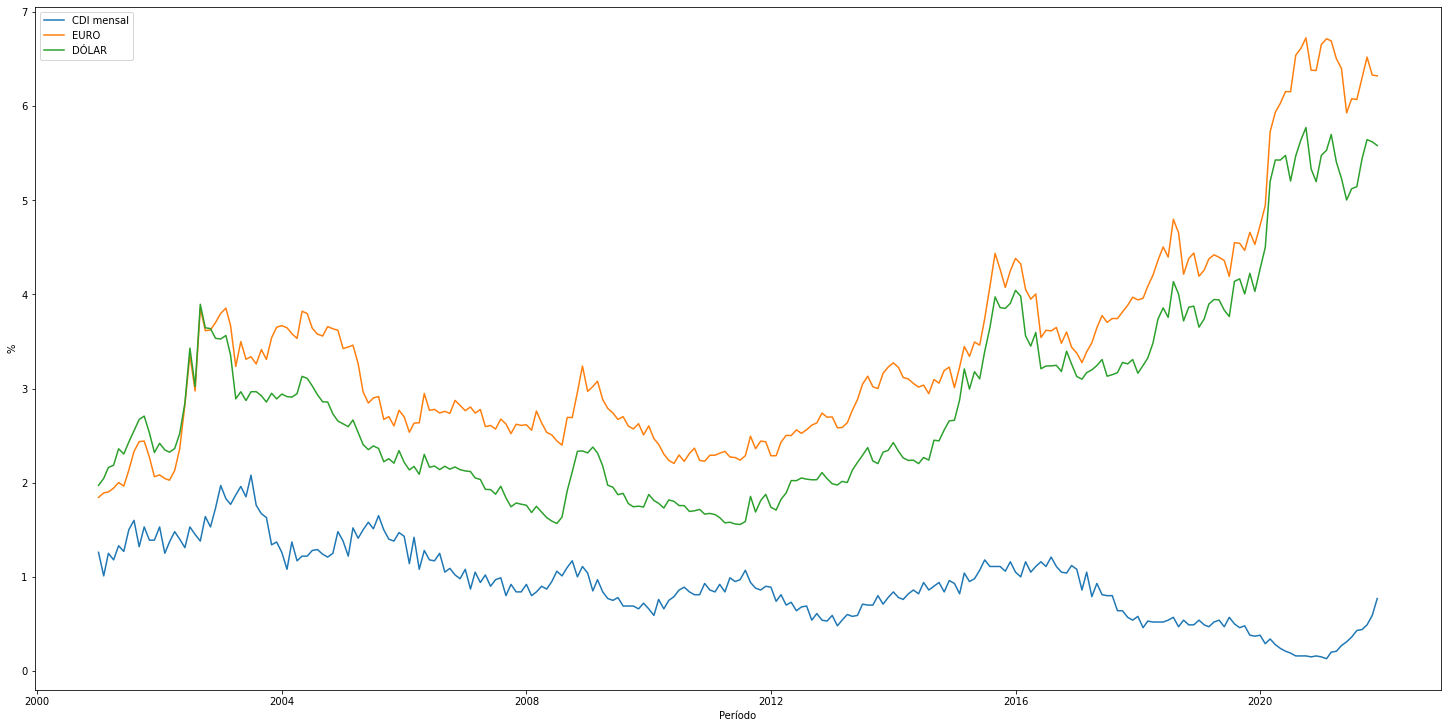

In [13]:
fig, graf2 = plt.subplots(figsize=(20, 10), layout='constrained')
graf2.plot('CDI', label='CDI mensal', data=df_completo, linewidth=1.5)
graf2.plot('EURO', label='EURO', data=df_completo, linewidth=1.5)
graf2.plot('USD', label='DÓLAR', data=df_completo, linewidth=1.5)

graf2.set_xlabel('Período')
graf2.set_ylabel('%')
graf2.legend()

In [ ]:
completo = pd.merge(df, dado_ajustados, how='left', left_index=True, right_index=True)
print(list(completo['Euribor 3M']))

In [ ]:
completo['Euribor 3M']

In [ ]:
_ = [dado_ajustados['Ano'].values.astype('str'), dado_ajustados['Mes'].values.astype('str')]
teste[0][0] + teste[1][0]

In [ ]:

teste        

In [ ]:
dict_meses = dict(dado_ajustados['Mes'].unique(), list(range(1,13)))
dict_meses

In [ ]:
def converteMes(mes):
    dict_meses = {'Janeiro': 1,
                  'Fevereiro': 2,
                  'Março': 3,
                  'Abril': 4, 
                  'Maio': 5,
                  'Junho': 6,
                  'Julho': 7,
                  'Agosto': 8,
                  'Setembro': 9,
                  'Outubro': 10,
                  'Novembro': 11,
                  'Dezembro': 12}
    return dict_meses[mes]


In [ ]:
dado_ajustados['Mes'] = dado_ajustados['Mes'].apply(converteMes)
dado_ajustados

In [ ]:
str(euribor2).split('\n')

In [ ]:
len(str(euribor2).split('\n'))

In [72]:
## EURIBOR
anos = np.arange(21) + 2001
dados_ajustados = pd.DataFrame()
for ano in anos:
    url_euribor = f'https://www.euribor-rates.eu/en/euribor-rates-by-year/{ano}/'
    conexao = urllib3.PoolManager()
    retorno = conexao.request('GET', url_euribor)
    pagina = BeautifulSoup(retorno.data, 'html.parser')
    tabela = pagina.find_all('table', class_='table-striped')
    dado = []
    for celulas in tabela:
        celula = celulas.find_all('td')
        for dados in celula:
            dado.append(dados.find(text=True))
    indice = []
    for celulas in tabela:
        celula = celulas.find_all('th')
        for dados in celula:
            indice.append(dados.find(text=True))
    linhas = 12
    colunas = int(len(dado)/12)
    dados_compilados = np.reshape(dado, (linhas, colunas))
    dados_compilados = pd.DataFrame(dados_compilados, index=[indice[-12:]], columns=[indice[1:-12]])
    dados_compilados.to_excel(f'EURIBO_3M_{ano}.xlsx', )


In [83]:
dados_ajustados = pd.DataFrame()

for ano in anos:
    euribor = pd.read_excel(f'EURIBO_3M_{ano}.xlsx')

    dados_ajustados = pd.concat([dados_ajustados, euribor])
    
    
dados_ajustados.to_excel(f'EURIBOR_3M_2001_2021.xlsx', )  

In [82]:
dados_ajustados['Unnamed: 0']

0            NaN
1      12/3/2001
2      11/1/2001
3     10/15/2001
4      10/1/2001
         ...    
8       5/3/2021
9       4/1/2021
10      3/1/2021
11      2/1/2021
12      1/4/2021
Name: Unnamed: 0, Length: 273, dtype: object